In [ ]:
import fastcore.all as fc

In [ ]:
url = 'https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz'

In [ ]:
from pathlib import Path
import pickle,gzip, math,os,time,shutil,matplotlib as mpl,matplotlib.pyplot as plt
from glob import glob
from torch import tensor

from miniai.datasets import *

In [ ]:
path = Path('data/camvid')

In [ ]:
if not path.exists():
    path_tgz = fc.urlsave(url, 'data')
    shutil.unpack_archive(str(path_tgz), 'data')

In [ ]:
path.ls()

(#4) [Path('data/camvid/labels'),Path('data/camvid/codes.txt'),Path('data/camvid/images'),Path('data/camvid/valid.txt')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
fnames = glob(str(path_img/'*.png'))
lbl_names = glob(str(path_lbl/'*.png'))

In [ ]:
img_f = Path(fnames[0])

In [ ]:
img_f

Path('data/camvid/images/0001TP_007050.png')

In [ ]:
from torchvision.io import read_image

In [ ]:
img = read_image(str(img_f))
img.shape

torch.Size([3, 720, 960])

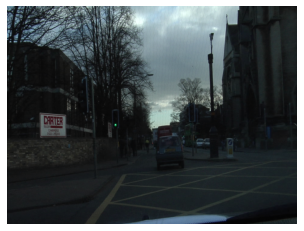

In [ ]:
show_image(img);

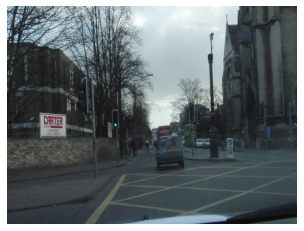

In [ ]:
show_image(((img/255).clamp(0.001,0.999).logit()+1).sigmoid());

In [ ]:
def get_y_fn(x): return path_lbl/f'{x.stem}_P{x.suffix}'

In [ ]:
mask_f = get_y_fn(img_f)

In [ ]:
mask = read_image(str(mask_f))
mask.shape

torch.Size([1, 720, 960])

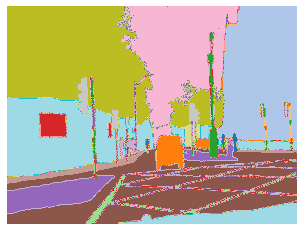

In [ ]:
show_image(mask, cmap='tab20');

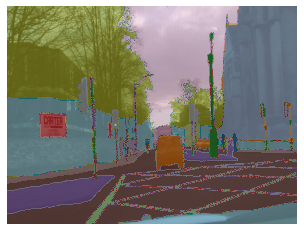

In [ ]:
ax = show_image(img)
show_image(mask, ax=ax, cmap='tab20', alpha=0.5);

In [ ]:
codes = (path/'codes.txt').read_text().splitlines(False)
' '.join(codes)

'Animal Archway Bicyclist Bridge Building Car CartLuggagePram Child Column_Pole Fence LaneMkgsDriv LaneMkgsNonDriv Misc_Text MotorcycleScooter OtherMoving ParkingBlock Pedestrian Road RoadShoulder Sidewalk SignSymbol Sky SUVPickupTruck TrafficCone TrafficLight Train Tree Truck_Bus Tunnel VegetationMisc Void Wall'

In [ ]:
codes[26]

'Tree'

In [ ]:
src_size = tensor(mask.shape[1:])

In [ ]:
valids = (path/'valid.txt').read_text().splitlines(False)
valids[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [ ]:
img = read_image(str(img_f))
img.shape

torch.Size([3, 720, 960])

In [ ]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
from fastai.vision.all import *

In [ ]:
bs = 8

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=bs, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str),
    item_tfms=Resize((360,480))
)

In [ ]:
xb,yb = next(iter(dls.train))

In [ ]:
xb.shape

torch.Size([8, 3, 360, 480])

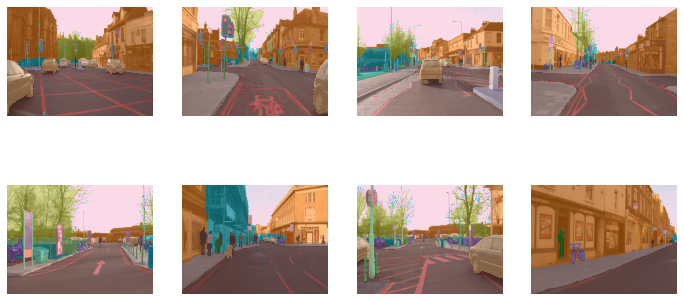

In [ ]:
dls.show_batch()

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/home/jhoward/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jhoward/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,1.693974,2.154445,00:25


epoch,train_loss,valid_loss,time
0,1.034159,0.814780,00:25
1,0.711367,0.604325,00:25
2,0.548157,0.493435,00:25
3,0.446590,0.482043,00:25
4,0.369599,0.403600,00:26
5,0.314844,0.387649,00:25
6,0.277619,0.372438,00:25
7,0.252502,0.374546,00:25


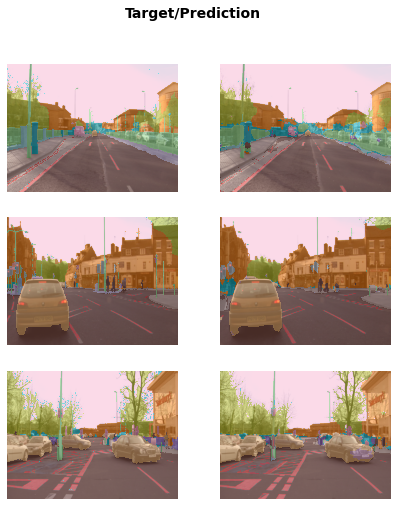

In [ ]:
learn.show_results(max_n=3, figsize=(7,8))